In [114]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
import ctypes
from ctypes import c_double, c_int, Structure


In [115]:
# IMPORTANT: NEED TO INSTALL ROS RO BE ABLE TO READ THE SIMULINK MODEL FOR NOW !
# sudo apt-get update
# sudo apt-get install libroscpp-dev

In [116]:
# Define the function prototype if necessary
# For example, if your function is named `updateVehicleState` and takes a pointer to VehicleState and a double dt
# updateVehicleState = lib.updateVehicleState
# updateVehicleState.argtypes = [ctypes.POINTER(VehicleState), c_double]
# updateVehicleState.restype = None

In [117]:
class VehicleState(Structure):
    _fields_ = [("x", c_double),
                ("y", c_double),
                ("yaw", c_double),
                ("v_x", c_double),
                ("v_y", c_double),
                ("r", c_double),
                ("a_x", c_double),
                ("a_y", c_double),
                ("steer", c_double)]


In [118]:
import time
import ctypes
import os

# Define realT type used by the shared library
real_T = ctypes.c_double

class Vehicle:

    def __init__(self):
        
        # Add the current directory to LD_LIBRARY_PATH
        current_dir = os.getcwd()
        current_ld_library_path = os.environ.get('LD_LIBRARY_PATH', '')
        new_ld_library_path = os.path.abspath('.') + ':' + current_ld_library_path
        os.environ['LD_LIBRARY_PATH'] = new_ld_library_path

        # Construct the full path to the shared library
        libvehicle_path = os.path.join(current_dir, 'libvehicle_and_lowlevel_control.so')

        # Load the shared library
        self.lib = ctypes.CDLL(libvehicle_path)



        # Define CarModel model class
        CarModel_new = self.lib.CarModel_new
        CarModel_new.restype = ctypes.c_void_p

        # Define the initialize method of the CarModel class
        CarModel_initialize = self.lib.CarModel_initialize
        CarModel_initialize.argtypes = [ctypes.c_void_p]

        # Define the destructor of the CarModel class
        self.CarModel_delete = self.lib.CarModel_delete
        self.CarModel_delete.argtypes = [ctypes.c_void_p]
        
        # Create an instance of the car model and initialize it
        self.car_model_instance = CarModel_new()
        CarModel_initialize(self.car_model_instance)

        # Set state to 0
        self.state = {
            'x': 0.0, 'y': 0.0, 'yaw': 0.0,
            'v_x': 0.0, 'v_y': 0.0, 'r': 0.0,
            'a_x': 0.0, 'a_y': 0.0, 'steer': 0.0,
        }

        # Define the variables to be used in the step function
        self.arg_x = real_T()
        self.arg_y = real_T()
        self.arg_phi = real_T()

        self.arg_VE_vx, self.arg_VE_vy, self.arg_VE_r  = real_T(), real_T(), real_T()
        self.arg_VE_ax, self.arg_VE_ay = real_T(), real_T()

        self.arg_steering_rad, self.arg_steering_rate, self.arg_steering_torque = real_T(), real_T(), real_T()

        self.arg_DV_DC, self.arg_DV_delta, self.arg_yaw_moment_target = real_T(), real_T(), real_T()

        # Define the time step
        dt = 0.5

        self.step_func = self.lib.CarModel_step
        self.step_func.argtypes = [
            ctypes.c_void_p,  # instance pointer
            real_T, real_T,  # tuning_param_key, tuning_param_value
            real_T, real_T,  # Command_throttle, Command_steering
            real_T, real_T, real_T,  # a_x_target0, a_x_target1, a_x_target2
            real_T, real_T, real_T,  # delta_target0, delta_target1, delta_target2
            real_T, real_T, real_T,  # yawrate_target0, yawrate_target1, yawrate_target2
            real_T, real_T, real_T,  # vx_mpc0, vx_mpc1, vx_mpc2
            real_T, real_T, real_T,  # vy_mpc0, vy_mpc1, vy_mpc2
            real_T, real_T, real_T,  # F_x_target_FL_0, F_x_target_FL_1, F_x_target_FL_2
            real_T, real_T, real_T,  # F_x_target_FR_0, F_x_target_FR_1, F_x_target_FR_2
            real_T, real_T, real_T,  # F_x_target_RL_0, F_x_target_RL_1, F_x_target_RL_2
            real_T, real_T, real_T,  # F_x_target_RR_0, F_x_target_RR_1, F_x_target_RR_2
            ctypes.POINTER(real_T), ctypes.POINTER(real_T), ctypes.POINTER(real_T),  # &arg_x, &arg_y, &arg_phi
            ctypes.POINTER(real_T), ctypes.POINTER(real_T), ctypes.POINTER(real_T),  # &arg_VE_vx, &arg_VE_vy, &arg_VE_r
            ctypes.POINTER(real_T), ctypes.POINTER(real_T),  # &arg_VE_ax, &arg_VE_ay
            (real_T * 4),  # arg_Fz
            ctypes.POINTER(real_T), ctypes.POINTER(real_T), ctypes.POINTER(real_T),  # &arg_steering_rad, &arg_steering_rate, &arg_steering_torque
            (real_T * 4), (real_T * 4), (real_T * 4),  # arg_wheel_speed, arg_wheel_speed_max, arg_wheel_speed_min
            (real_T * 4), (real_T * 4),  # arg_wheel_torque, arg_wheel_torque_target
            ctypes.POINTER(real_T), ctypes.POINTER(real_T), ctypes.POINTER(real_T),  # &arg_DV_DC, &arg_DV_delta, &arg_yaw_moment_target
        ]

        self.step_func.restype = None 


    def update_dynamics(self, dt, input_command):
        
        throttle_input = input_command['throttle']
        steering_input = input_command['steering']

        for _ in range(int(dt/0.001)):
            self.step_func(self.car_model_instance,
                    real_T(0), real_T(0),  # example values for the first two parameters
                    real_T(throttle_input), real_T(steering_input),  # example values for the first two parameters
                    real_T(0), real_T(0),real_T(0),
                    real_T(0), real_T(0),real_T(0),
                    real_T(0), real_T(0),real_T(0), 
                    real_T(0), real_T(0),real_T(0),
                    real_T(0), real_T(0),real_T(0),
                    real_T(0), real_T(0),real_T(0),
                    real_T(0), real_T(0),real_T(0),
                    real_T(0), real_T(0),real_T(0),
                    real_T(0), real_T(0),real_T(0),
                    ctypes.byref(self.arg_x), ctypes.byref(self.arg_y), ctypes.byref(self.arg_phi),
                    ctypes.byref(self.arg_VE_vx), ctypes.byref(self.arg_VE_vy), ctypes.byref(self.arg_VE_r),
                    ctypes.byref(self.arg_VE_ax), ctypes.byref(self.arg_VE_ay),
                    (real_T * 4)(10.0, 10.0, 10.0, 10.0),
                    ctypes.byref(self.arg_steering_rad), ctypes.byref(self.arg_steering_rate), ctypes.byref(self.arg_steering_torque),
                    (real_T * 4)(0.0, 0.0, 0.0, 0.0), (real_T * 4)(0.0, 0.0, 0.0, 0.0), (real_T * 4)(0.0, 0.0, 0.0, 0.0),
                    (real_T * 4)(0.0, 0.0, 0.0, 0.0), (real_T * 4)(0.0, 0.0, 0.0, 0.0), (real_T * 4)(0.0, 0.0, 0.0, 0.0),
                    ctypes.byref(self.arg_DV_DC), ctypes.byref(self.arg_DV_delta), ctypes.byref(self.arg_yaw_moment_target)
                    )

    def get_state(self):
        self.state['x'] = self.arg_x.value
        self.state['y'] = self.arg_y.value
        self.state['yaw'] = self.arg_phi.value
        self.state['v_x'] = self.arg_VE_vx.value
        self.state['v_y'] = self.arg_VE_vy.value
        self.state['r'] = self.arg_VE_r.value
        self.state['a_x'] = self.arg_VE_ax.value
        self.state['a_y'] = self.arg_VE_ay.value
        self.state['steer'] = self.arg_steering_rad.value

        return self.state
    
    def Destructor(self):
        self.CarModel_delete(self.car_model_instance)


In [119]:
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation, PillowWriter
def main():
    vehicle = Vehicle()
    dt = 0.1  # Time step

    fig, ax = plt.subplots()
    ax.axis('equal')
    ax.set_xlim(-10, 50)
    ax.set_ylim(-20, 20)

    # Define car dimensions
    car_length = 2.0
    car_width = 1.0
    wheel_length = 0.4
    wheel_width = 0.15

    # Initialize car body and wheels
    car_body = patches.Rectangle((0, 0), car_length, car_width, color='blue', angle=np.degrees(vehicle.state['yaw']))
    ax.add_patch(car_body)

    wheels = []
    for _ in range(4):
        wheel = patches.Rectangle((0, 0), wheel_length, wheel_width, color='black')
        ax.add_patch(wheel)
        wheels.append(wheel)

    def animate(i):
        current_time = i * dt
        steering_input = 0.3 * np.sin(2 * np.pi * current_time / 3)
        input_command = {'throttle': 1.0, 'steering': steering_input}
        vehicle.update_dynamics(dt, input_command)
        state = vehicle.get_state()

        # Update car body
        car_center_x = state['x'] + car_length / 2 * np.cos(state['yaw'])
        car_center_y = state['y'] + car_length / 2 * np.sin(state['yaw'])
        car_body.set_xy((state['x'], state['y']))
        car_body.angle = np.degrees(state['yaw'])

        # Set plot limits to follow the car
        view_margin = 10  # Margin around the car for the plot view
        ax.set_xlim(state['x'] - view_margin, state['x'] + view_margin)
        ax.set_ylim(state['y'] - view_margin, state['y'] + view_margin)
        # Activate the grid
        ax.grid(True)

        # Positions of the wheels relative to the car center
        wheel_positions = [(car_length * 0.5 + car_length * 0.25 - wheel_length*0.5, car_width * 0.5 + car_width * 0.5 - wheel_width*0.5, np.degrees(state['yaw'])), 
                        (car_length * 0.5 + car_length * 0.25 - wheel_length*0.5, car_width * 0.5 -car_width * 0.5 - wheel_width*0.5, np.degrees(state['yaw'])),
                        (car_length * 0.5 -car_length * 0.25 - wheel_length*0.5, car_width * 0.5 + car_width * 0.5 - wheel_width*0.5, np.degrees(state['yaw'])),
                        (car_length * 0.5 -car_length * 0.25 - wheel_length*0.5, car_width * 0.5 -car_width * 0.5 - wheel_width*0.5, np.degrees(state['yaw']))]

        for wheel, (x_offset, y_offset, angle) in zip(wheels, wheel_positions):
            # Calculate the global position of each wheel
            wheel_x = state['x'] + x_offset * np.cos(state['yaw']) - y_offset * np.sin(state['yaw'])
            wheel_y = state['y'] + x_offset * np.sin(state['yaw']) + y_offset * np.cos(state['yaw'])
            wheel.set_xy((wheel_x, wheel_y))
            wheel.angle = angle

    # Creating the animation
    anim = FuncAnimation(fig, animate, frames=np.arange(0, 100, dt), interval=dt*1000)

    plt.show()

    f = r"./animation.gif" 
    writergif = PillowWriter(fps=30) 
    anim.save(f, writer=writergif)


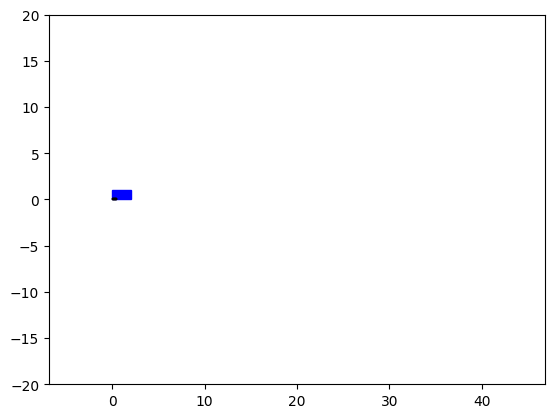

In [120]:
main()